In [1]:
"""
Modified LSTM to work on a bigger multiclass extract and tuned it a bit.

This is the final LSTM model we ended up using.

Author: Wesley
"""
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import io # StringIO
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, Conv2D, GlobalMaxPooling2D,GlobalMaxPooling1D, MaxPool1D, MaxPool2D
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import classification_report

In [2]:
multiclass_train = pd.read_csv("multiclass_train.csv")
multiclass_test = pd.read_csv("multiclass_test.csv")

In [3]:
# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()
multiclass_train[" Label"] = le.fit_transform(multiclass_train[" Label"].values)

multiclass_test[" Label"] = le.transform(multiclass_test[" Label"].values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multiclass_train[' Label']))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)


Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [4]:
y_train = multiclass_train[" Label"].copy()
X_train = multiclass_train.drop([" Label"], axis=1)

y_test = multiclass_test[" Label"].copy()
X_test = multiclass_test.drop([" Label"], axis=1)

In [5]:
scal = StandardScaler()
scal = scal.fit(X_train)
X_test = scal.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, stratify=y_train, random_state=42)
X_train = scal.fit_transform(X_train)
X_val = scal.transform(X_val)

In [6]:
n_feat = 80
X_tr = np.reshape(X_train, (len(X_train), n_feat, 1))
X_vl = np.reshape(X_val, (len(X_val), n_feat, 1))
X_tst = np.reshape(X_test, (len(X_test), n_feat, 1))

In [7]:
print(X_tr.shape)
print(y_train.shape)

(129838, 80, 1)
(129838,)


In [8]:
model = keras.Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=X_tr.shape[1:3]))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters = 128, kernel_size = 3, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters = 256, kernel_size = 3, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters = 512, kernel_size = 3, activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='softmax'))

opt = keras.optimizers.Adadelta(learning_rate=0.1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8, 256)           0

In [9]:
history=model.fit(X_tr, y_train.to_numpy(), validation_data = (X_vl, y_val.to_numpy()), batch_size=128, epochs=100, callbacks = [reduce_lr,model_checkpoint_callback])

Epoch 1/100
1015/1015 [==============================] - 10s 8ms/step - loss: 1.1105 - sparse_categorical_accuracy: 0.5770 - val_loss: 0.8713 - val_sparse_categorical_accuracy: 0.6381 - lr: 0.1000
Epoch 2/100
1015/1015 [==============================] - 8s 8ms/step - loss: 0.8051 - sparse_categorical_accuracy: 0.6588 - val_loss: 0.8168 - val_sparse_categorical_accuracy: 0.6481 - lr: 0.1000
Epoch 3/100
1015/1015 [==============================] - 8s 8ms/step - loss: 0.7581 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.7554 - val_sparse_categorical_accuracy: 0.6827 - lr: 0.1000
Epoch 4/100
1015/1015 [==============================] - 8s 8ms/step - loss: 0.7339 - sparse_categorical_accuracy: 0.6843 - val_loss: 0.7636 - val_sparse_categorical_accuracy: 0.6833 - lr: 0.1000
Epoch 5/100
1015/1015 [==============================] - 8s 8ms/step - loss: 0.7183 - sparse_categorical_accuracy: 0.6895 - val_loss: 0.7394 - val_sparse_categorical_accuracy: 0.6786 - lr: 0.1000
Epoch 6/100
1015/10

In [10]:
#history=model.fit(X_tr, y_train.to_numpy(), batch_size=len(X_tr), epochs=10)
path_new_model = "CNN_multi_final.h5"

#Save final model
model.save(path_new_model)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


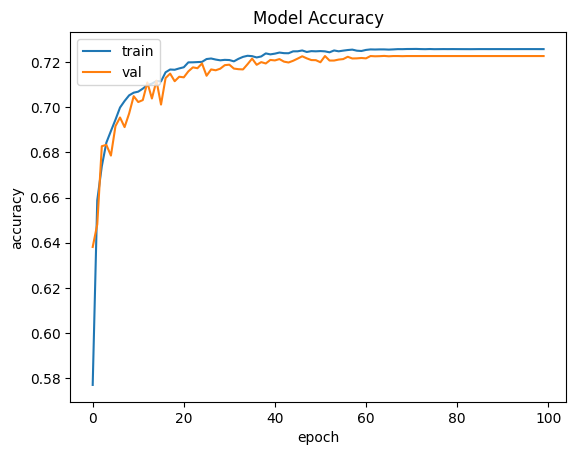

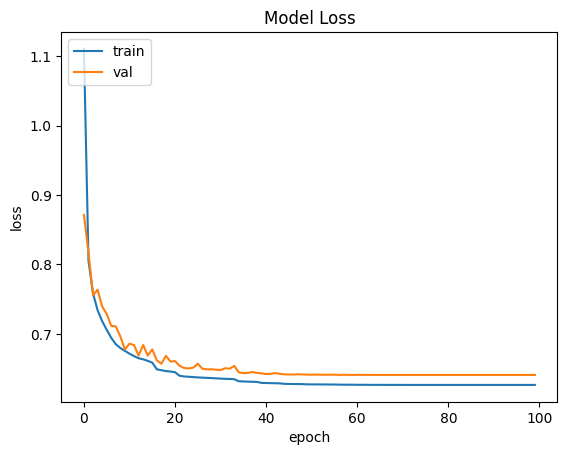

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
#Test predictions
#model.load_weights(checkpoint_filepath)
prediction = model.predict(X_tst)

1160/1160 [==============================] - 2s 2ms/step


In [17]:
#pred = [1 if prediction[i] >= 0.5 else 0 for i in range(len(prediction))]
pred = [np.argmax(x) for x in prediction]
pd.Series(pred).value_counts()

10    4775
2     4640
6     3790
5     3590
1     3464
3     3105
9     3080
8     2987
11    2470
7     2038
4     1650
0     1508
dtype: int64

In [18]:
print(classification_report(y_test.to_numpy(), pred, digits=6,target_names=multiclass_labels))

              precision    recall  f1-score   support

         DNS   0.635942  0.310256  0.417047      3091
        LDAP   0.577079  0.646716  0.609916      3091
       MSSQL   0.602371  0.904238  0.723063      3091
         NTP   0.975523  0.979625  0.977570      3092
     NetBIOS   0.831515  0.443726  0.578659      3092
     Portmap   0.728969  0.846652  0.783416      3091
        SNMP   0.624274  0.765201  0.687591      3092
        SSDP   0.453386  0.298836  0.360234      3092
         Syn   0.998661  0.965060  0.981573      3091
        TFTP   0.998701  0.995147  0.996921      3091
         UDP   0.461361  0.712714  0.560132      3091
     UDP-lag   0.947773  0.757115  0.841784      3092

    accuracy                       0.718764     37097
   macro avg   0.736296  0.718774  0.709825     37097
weighted avg   0.736300  0.718764  0.709823     37097



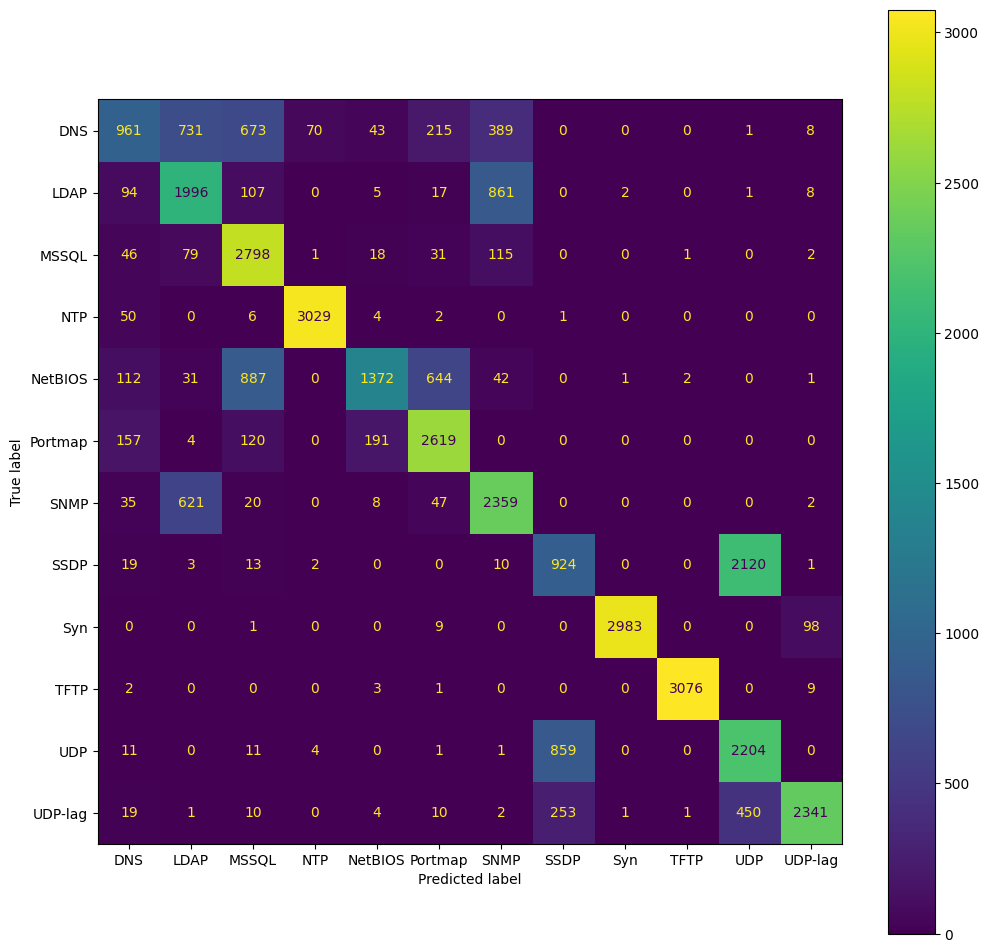

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.savefig("confusion_multi_cnn.png")